In [1]:
import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from itertools import permutations

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
from plot_triad import plot_one_triad_pretty_pro
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # has wide Unicode support


# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

In [2]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [3]:
df_country = pd.read_csv(DATA_DIR/f"all.csv") 
df_country = df_country[['name', 'alpha-2', 'region', 'sub-region']]
df_country

,name,alpha-2,region,sub-region
0,Afghanistan,AF,Asia,Southern Asia
1,Åland Islands,AX,Europe,Northern Europe
2,Albania,AL,Europe,Southern Europe
3,Algeria,DZ,Africa,Northern Africa
4,American Samoa,AS,Oceania,Polynesia
...,...,...,...,...
244,Wallis and Futuna,WF,Oceania,Polynesia
245,Western Sahara,EH,Africa,Northern Africa
246,Yemen,YE,Asia,Western Asia
247,Zambia,ZM,Africa,Sub-Saharan Africa


In [4]:
# # Define the mapping of old codes to new codes
# country_code_mapping = {
#     'GR': 'EL',  # Greece (GR → EL)
#     'GB': 'UK'   # United Kingdom (GB → UK)
# }

# # Apply the replacement to both dfs
# df['country_from'] = df['country_from'].replace(country_code_mapping)
# df['country_to'] = df['country_to'].replace(country_code_mapping)
# df_country['alpha-2'] = df_country['alpha-2'].replace(country_code_mapping)

# Prep data

In [4]:
# Keep only what we need and rename to the model’s expected names
df_flow = (df
      .rename(columns={
          "country_from": "orig",
          "country_to": "dest",
          # "migration_month": "month",
          "num_migrants": "flow"
      })
      [["orig", "dest", "migration_month", "flow"]].copy()).rename(columns={
          "migration_month": "month"      })

# Make sure month is monthly datetime (month-start)
# df_flow["month"] = pd.to_datetime(df["month"]).dt.to_period("M").dt.to_timestamp()

# Clean types
df_flow["orig"] = df_flow["orig"].astype(str).str.upper()
df_flow["dest"] = df_flow["dest"].astype(str).str.upper()
df_flow["flow"] = pd.to_numeric(df_flow["flow"], errors="coerce").fillna(0).clip(lower=0).astype(int)

# If there are accidental duplicates (same orig-dest-month), aggregate
# df_flow = (df_flow.groupby(["orig", "dest", "month"], as_index=False)["flow"].sum())

df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


In [5]:
duplicates = df_flow.duplicated(subset=["orig", "dest", "month"], keep=False)
duplicate_rows = df_flow[duplicates]
duplicate_rows

,orig,dest,month,flow


# Define Triads

## Example 

In [28]:
# Define triads in YOUR code system (ISO-2 in your case)
triads = [
    ("VE","CL","US"),   # VE→CL→US
    ("VE","PE","US"),   # VE→PE→US
    ("VE","EC","US"),   # VE→EC→US
    ("VE","MX","US"),   # VE→MX→US  (big exporter j example)
    ("HT","DO","US"),   # Haiti chain
    ("AR","UY","ES"),   # Argentina→Uruguay→Spain
    ("SY","TR","DE")    # Syria→Turkey→Germany
]

## By Region

In [6]:
def get_country_list(df_country, values, level="sub-region", extra_countries=None):
    """
    Returns a list of country codes (alpha-2) based on region or sub-region,
    with an option to manually add more countries.

    Parameters:
        df_country (pd.DataFrame): Country metadata with 'alpha-2', 'region', and 'sub-region'.
        values (str or list): One or multiple regions/sub-regions to filter by.
        level (str): Either "region" or "sub-region" (default = "sub-region").
        extra_countries (list, optional): List of additional alpha-2 country codes to include.

    Returns:
        list: List of unique country codes.
    """
    # Ensure values is a list for flexibility
    if isinstance(values, str):
        values = [values]

    # Validate input for level
    if level not in ["region", "sub-region"]:
        raise ValueError("level must be either 'region' or 'sub-region'")

    # Get the countries from df_country
    country_list = df_country.loc[df_country[level].isin(values), "alpha-2"].unique().tolist()

    # Add extra countries if provided
    if extra_countries:
        country_list = list(set(country_list) | set(extra_countries))

    return sorted(country_list)

In [8]:
# df_country["sub-region"].unique()
len(df_country[df_country['sub-region'] == 'Latin America and the Caribbean']['alpha-2'].unique())

52

In [9]:
df_country[df_country['sub-region'] == 'Americas']

,name,alpha-2,region,sub-region


In [10]:
# ------- Usage ---------
# # 1. Get Countries from a Single Sub-Region
# countries = get_country_list(df_country, "Southern Europe", level="sub-region")

# # 2. Get Countries from Multiple Sub-Regions
# countries = get_country_list(
#     df_country,
#     ["Southern Europe", "Northern Europe"],
#     level="sub-region"
# )

# # 3. Get Countries from a Whole Region
# countries = get_country_list(df_country, "Asia", level="region")

# 4. Add Extra Countries Manually
countries = get_country_list(
    df_country,
    "Latin America and the Caribbean",
    level="sub-region",
    # extra_countries=["ES", "GB", "IT"]
)

len(countries)

52

In [12]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

# triads[:5]
len(triads)

504

## Define 

In [23]:
# countries = ['CL', 'BR', 'ES', 'PE', 'US', 'EC', 'AR', 'VE', 'CO', 'CR', 'NI', 'MX']
countries = ['CL', 'PE', 'US', 'AR', 'VE', 'CO', 'CR', 'NI', 'MX']
# countries = ['CL', 'US', 'NI', 'MX']

In [24]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

# triads[:5]
len(triads)

504

# eop_pro_plus

In [29]:
from eop_pro_plus import EOPProPlus, EOPPlusConfig

In [30]:
cfg = EOPPlusConfig(
    train_end="2021-12-01",
    val_start="2021-07-01",
    include_pair_fe=True,
    include_origin_time_fe=True,   # absorbs j-wide export surges
    include_dest_time_fe=True,     # absorbs k-wide policy shocks
    use_global_time_fe=False,
    add_sci=False,                 # set True only if you pass an SCI table below
    # weight_mode="excess_share",    # only attribute when i’s share in j > baseline
    weight_mode="share",    # only attribute when i’s share in j > baseline
    progress=True,       # show tqdm
    pbar_leave=False,    # don't leave bars on screen after finishing
    pbar_ncols=80
)

# Fit baseline on your data
model = EOPProPlus(cfg, sci_df=None).fit(df_flow)   # shows “Grid search α”

# Compute EOP (standardized anomalies by default)
eop   = model.eop_index(df_flow, triads, use_standardized=True)  # shows “EOP triads”

Grid search α:   0%|                                      | 0/5 [00:00<?, ?it/s]

EOP triads:   0%|                                         | 0/7 [00:00<?, ?it/s]

In [31]:
eop

,i,j,k,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP
240,AR,UY,ES,2019-01-01,351.0,305.120428,0.720617,0.144933,0.104441
241,AR,UY,ES,2019-02-01,561.0,430.957498,1.718655,0.156016,0.268137
242,AR,UY,ES,2019-03-01,811.0,554.136231,2.993748,0.147662,0.442062
243,AR,UY,ES,2019-04-01,594.0,477.342854,1.464930,0.153051,0.224209
244,AR,UY,ES,2019-05-01,551.0,462.351302,1.131116,0.154213,0.174432
...,...,...,...,...,...,...,...,...,...
91,VE,PE,US,2022-08-01,11343.0,17.215844,748.901772,0.432037,323.553439
92,VE,PE,US,2022-09-01,13345.0,17.215844,881.281246,0.433824,382.321083
93,VE,PE,US,2022-10-01,16403.0,17.215844,1083.487255,0.428294,464.051389
94,VE,PE,US,2022-11-01,9258.0,17.215844,611.034038,0.420579,256.987917


In [19]:
# eop has:
# ['i','j','k','month','flow_jk','mu_hat_jk','anom_jk','w_ij','EOP']
# eop.head()

eop

,i,j,k,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP
240,AR,UY,ES,2019-01-01,351.0,305.120428,0.720617,0.000000,0.000000
241,AR,UY,ES,2019-02-01,561.0,430.957498,1.718655,0.000000,0.000000
242,AR,UY,ES,2019-03-01,811.0,554.136231,2.993748,0.000000,0.000000
243,AR,UY,ES,2019-04-01,594.0,477.342854,1.464930,0.000000,0.000000
244,AR,UY,ES,2019-05-01,551.0,462.351302,1.131116,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
91,VE,PE,US,2022-08-01,11343.0,17.215844,748.901772,0.004914,3.680157
92,VE,PE,US,2022-09-01,13345.0,17.215844,881.281246,0.006701,5.905463
93,VE,PE,US,2022-10-01,16403.0,17.215844,1083.487255,0.001171,1.268902
94,VE,PE,US,2022-11-01,9258.0,17.215844,611.034038,0.000000,0.000000


## (Optional) Add Social Connectedness (SCI)

In [ ]:
orig,dest,sci
VE,US,1.2e-5
VE,ES,9.5e-6
...

In [ ]:
sci = pd.read_csv("your_sci.csv")  # columns: orig, dest, sci (non-negative)
sci["orig"] = sci["orig"].str.upper()
sci["dest"] = sci["dest"].str.upper()

cfg_sci = cfg
cfg_sci.add_sci = True

model_sci = EOPProPlus(cfg_sci, sci_df=sci).fit(df)
eop_sci = model_sci.eop_index(df, triads, use_standardized=True)


## Check Result 

In [ ]:
# Peak month per triad
peaks = (eop.sort_values(["i","j","k","EOP"], ascending=[True,True,True,False])
           .groupby(["i","j","k"]).head(1)[["i","j","k","month","EOP"]])

# 2022 mean EOP by triad (or any window you like)
eop["year"] = eop["month"].dt.year
mean_2022 = (eop[eop["year"]==2022]
             .groupby(["i","j","k"])["EOP"].mean()
             .reset_index(name="EOP_2022_mean"))

print(peaks)
print(mean_2022)


## Plot 

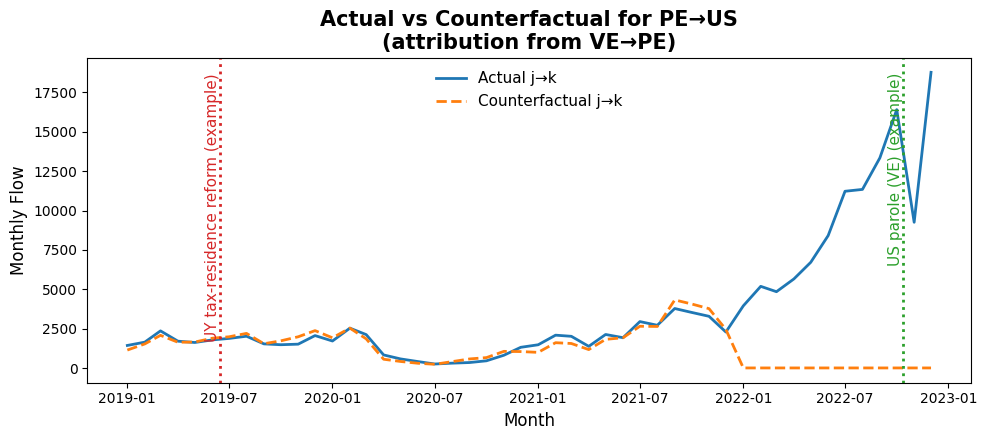

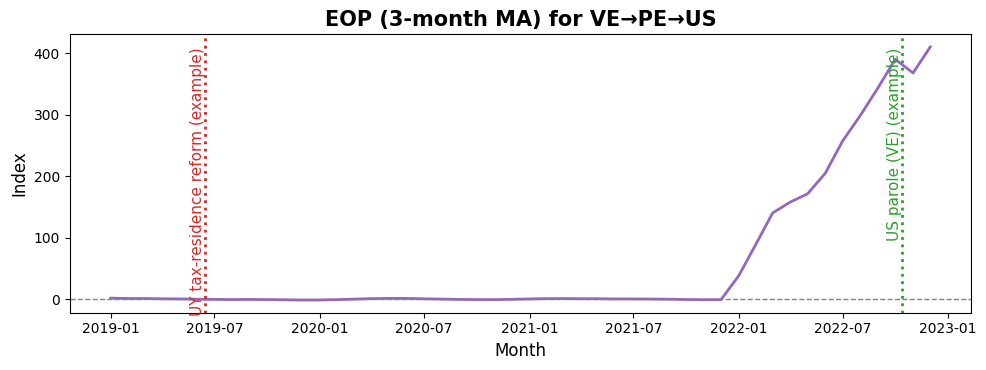

In [32]:
# Optional: policy lines (date, label, color)
policies = [
    ("2019-06-15", "UY tax‑residence reform (example)", "tab:red"),
    ("2022-10-12", "US parole (VE) (example)", "tab:green"),
]

# Optional: custom line colors
line_colors = {"actual": "tab:blue", "counterfactual": "tab:orange", "eop": "tab:purple"}

# Example 1 — AR→UY→ES (your snippet)
plot_one_triad_pretty_pro(
    eop,
    i="VE", j="PE", k="US",
    ma=3,
    policies=policies,          # or None if you don't want markers
    line_colors=line_colors,    # omit to use matplotlib defaults
    yscale="linear",            # or "log" if flows span big magnitudes
    eop_col="EOP",              # your EOP column
    # pred_col auto-detects 'mu_hat_jk'; if you were using EOP-Lite pass pred_col="ehat_jk"
)

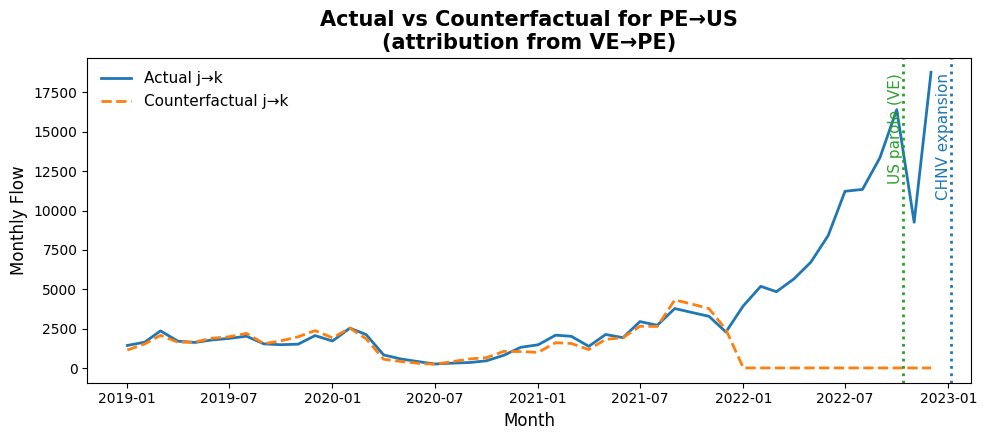

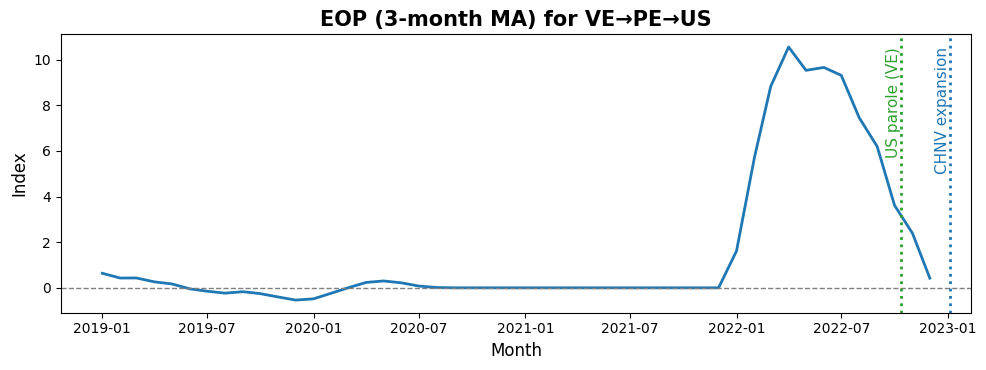

In [13]:
# Example 2 — VE→PE→US
plot_one_triad_pretty_pro(
    eop,
    "VE", "PE", "US",
    ma=3,
    policies=[
        ("2022-10-12", "US parole (VE)", "tab:green"),
        ("2023-01-05", "CHNV expansion", "tab:blue"),  # will draw even if outside data window
    ],
)


# eop_lite

In [5]:
from eop_lite import CounterfactualConfig, compute_eop_lite

# ----------  A) STANDARDIZE YOUR SCHEMA  ----------
def standardize_user_schema(df: pd.DataFrame) -> pd.DataFrame:
    """
    Turns your columns into the 4 columns the EOP calculator expects:
      orig, dest, month (datetime at month start), flow
    Works whether your codes are ISO2 or ISO3 (just be consistent in triads).
    """
    df = df.copy()

    # If there is an integer 'month' column (1..12), rename it to avoid collision
    if 'month' in df.columns and pd.api.types.is_integer_dtype(df['month']):
        df = df.rename(columns={'month': 'month_num'})

    # Rename core columns
    rename_map = {
        'country_from': 'orig',
        'country_to': 'dest',
        'migration_month': 'month',
        'num_migrants': 'flow'
    }
    df = df.rename(columns=rename_map)

    # Keep only what we need
    keep = ['orig', 'dest', 'month', 'flow']
    df = df[keep]

    # Clean up codes and dates
    df['orig'] = df['orig'].astype(str).str.strip().str.upper()
    df['dest'] = df['dest'].astype(str).str.strip().str.upper()
    df['month'] = pd.to_datetime(df['month']).values.astype('datetime64[M]')  # month start
    df['flow'] = pd.to_numeric(df['flow'], errors='coerce').fillna(0).astype(float)

    return df


In [6]:
flows = standardize_user_schema(df)
flows

,orig,dest,month,flow
0,AD,AE,2019-01-01,12.0
1,AD,AE,2019-02-01,2.0
2,AD,AE,2019-03-01,1.0
3,AD,AE,2019-04-01,7.0
4,AD,AE,2019-05-01,0.0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138.0
1563150,ZW,ZM,2022-09-01,162.0
1563151,ZW,ZM,2022-10-01,149.0
1563152,ZW,ZM,2022-11-01,104.0


## Define triads

### By region

In [7]:
def get_country_list(df_country, values, level="sub-region", extra_countries=None):
    """
    Returns a list of country codes (alpha-2) based on region or sub-region,
    with an option to manually add more countries.

    Parameters:
        df_country (pd.DataFrame): Country metadata with 'alpha-2', 'region', and 'sub-region'.
        values (str or list): One or multiple regions/sub-regions to filter by.
        level (str): Either "region" or "sub-region" (default = "sub-region").
        extra_countries (list, optional): List of additional alpha-2 country codes to include.

    Returns:
        list: List of unique country codes.
    """
    # Ensure values is a list for flexibility
    if isinstance(values, str):
        values = [values]

    # Validate input for level
    if level not in ["region", "sub-region"]:
        raise ValueError("level must be either 'region' or 'sub-region'")

    # Get the countries from df_country
    country_list = df_country.loc[df_country[level].isin(values), "alpha-2"].unique().tolist()

    # Add extra countries if provided
    if extra_countries:
        country_list = list(set(country_list) | set(extra_countries))

    return sorted(country_list)


In [20]:
# df_country["sub-region"].unique()
len(df_country[df_country['sub-region'] == 'Latin America and the Caribbean']['alpha-2'].unique())

52

In [8]:
# ------- Usage ---------
# # 1. Get Countries from a Single Sub-Region
# countries = get_country_list(df_country, "Southern Europe", level="sub-region")

# # 2. Get Countries from Multiple Sub-Regions
# countries = get_country_list(
#     df_country,
#     ["Southern Europe", "Northern Europe"],
#     level="sub-region"
# )

# # 3. Get Countries from a Whole Region
# countries = get_country_list(df_country, "Asia", level="region")

# 4. Add Extra Countries Manually
countries = get_country_list(
    df_country,
    "Americas",
    level="sub-region",
    extra_countries=["ES", "GB", "IT"]
)

len(countries)

60

In [9]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

triads[:5]

[('AG', 'AI', 'AR'),
 ('AG', 'AI', 'AW'),
 ('AG', 'AI', 'BB'),
 ('AG', 'AI', 'BL'),
 ('AG', 'AI', 'BM')]

### Write

In [16]:
# ----------  C) DEFINE TRIADS (use the SAME code system as in your file) ----------
triads = [
    ("VE","CL","US"),  # Venezuela -> Chile -> United States
    ("VE","PE","US"),  # Venezuela -> Peru  -> United States
    ("VE","EC","US"),  # Venezuela -> Ecuador -> United States
    ("VE","CO","US"),  # Venezuela -> Columbia -> United States
    ("VE","CL","ES"),  # Venezuela -> Chile -> Spain
    ("VE","PE","CL"),  # Venezuela -> Peru -> Chile
    ("CL","PE","VE"),  # Venezuela -> Peru -> Chile
    ("VE","PE","DE"),  # Venezuela -> Peru -> Chile
    ("VE","PE","UK"),  # Venezuela -> Peru -> Chile

    # ("HT","DO","US"),  # Haiti -> Dominican Republic -> United States
    # ("AR","UY","ES"),  # Argentina -> Uruguay -> Spain
    # ("SY","TR","DE"),  # Syria -> Türkiye -> Germany
]

### triads: permutations by country (LA)

In [5]:
# List of country codes
countries = ['CL', 'BR', 'ES', 'PE', 'US', 'EC', 'AR', 'VE', 'CO']

# Optional: Mapping of codes to full names
country_names = {
    'CL': 'Chile',
    'BR': 'Brazil',
    'ES': 'Spain',
    'PE': 'Peru',
    'US': 'United States',
    'EC': 'Ecuador',
    'AR': 'Argentina',
    'VE': 'Venezuela',
    'CO': 'Colombia'
}

[('CL', 'BR', 'ES'),
 ('CL', 'BR', 'PE'),
 ('CL', 'BR', 'US'),
 ('CL', 'BR', 'EC'),
 ('CL', 'BR', 'AR')]

In [37]:
latin_american_countries = [
    # South America
    'AR',  # Argentina
    'BO',  # Bolivia
    'BR',  # Brazil
    'CL',  # Chile
    'CO',  # Colombia
    'EC',  # Ecuador
    'GY',  # Guyana
    'PY',  # Paraguay
    'PE',  # Peru
    'SR',  # Suriname
    'UY',  # Uruguay
    'VE',  # Venezuela

    # Central America
    'BZ',  # Belize
    'CR',  # Costa Rica
    'SV',  # El Salvador
    'GT',  # Guatemala
    'HN',  # Honduras
    'NI',  # Nicaragua
    'PA',  # Panama

    # Mexico
    'MX',  # Mexico

    # Caribbean (Latin)
    'CU',  # Cuba
    'DO',  # Dominican Republic
    'PR',  # Puerto Rico (US territory but culturally Latin)
    'HT',  # Haiti (French/Creole-speaking, sometimes included)

    # Manually add US & CA
    'US','CA','ES'
]

countries = set(latin_american_countries) 
len(countries)

27

In [41]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

# triads[:5]
len(triads) 

17550

### triads: permutations by country (Global)

In [31]:
# Ensure both columns are strings
df['country_from'] = df['country_from'].astype(str)
df['country_to'] = df['country_to'].astype(str)

# Unique sets
unique_from = set(df['country_from'].unique())
unique_to = set(df['country_to'].unique())

# Overlap
overlap = unique_from.intersection(unique_to)

# Convert to sorted list
countries = sorted(list(overlap))

countries[:5]

['AD', 'AE', 'AF', 'AL', 'AM']

In [32]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

triads[:5]

[('AD', 'AE', 'AF'),
 ('AD', 'AE', 'AL'),
 ('AD', 'AE', 'AM'),
 ('AD', 'AE', 'AO'),
 ('AD', 'AE', 'AR')]

In [33]:
len(triads)

5831820

## Model 

In [28]:
# ----------  D) CONFIGURE THE COUNTERFACTUAL ----------
cfg = CounterfactualConfig(
    train_start="2019-01-01",        # training window for the baseline
    train_end="2021-12-01",
    corridor_specific_seasonality=False,  # flip to True if your corridors are not too sparse
    eps=1.0
)

In [29]:
# ----------  E) COMPUTE EOP-LITE ---------- 
eop = compute_eop_lite(flows, triads, cfg)
# Columns: ['i','j','k','month','flow_jk','ehat_jk','excess_jk','w_ij','eop_lite']
eop

Processing triads: 100%|█████████████| 17550/17550 [5:13:48<00:00,  1.07s/triad]


,i,j,k,month,flow_jk,ehat_jk,excess_jk,w_ij,eop_lite
19584,AR,BO,BR,2019-01-01,1996.0,1632.607330,0.222584,0.417661,0.092965
19585,AR,BO,BR,2019-02-01,2289.0,2162.286267,0.058602,0.397566,0.023298
19586,AR,BO,BR,2019-03-01,2255.0,2471.581254,-0.087629,0.381936,-0.033468
19587,AR,BO,BR,2019-04-01,1597.0,1651.618446,-0.033070,0.375685,-0.012424
19588,AR,BO,BR,2019-05-01,1538.0,1589.281593,-0.032267,0.366980,-0.011841
...,...,...,...,...,...,...,...,...,...
126571,VE,UY,US,2022-08-01,409.0,402.039314,0.017313,0.103161,0.001786
126572,VE,UY,US,2022-09-01,301.0,429.496188,-0.299179,0.105130,-0.031453
126573,VE,UY,US,2022-10-01,381.0,573.863282,-0.336079,0.107121,-0.036001
126574,VE,UY,US,2022-11-01,238.0,426.065375,-0.441400,0.107275,-0.047351


# Export

In [30]:
eop.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_27.csv", index=False)

In [ ]:
# eop = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_LA.csv") 
# eop = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop.csv") 
# eop

# Stats

In [50]:
eop_LA = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_LA.csv") 
eop_LA

,i,j,k,month,flow_jk,ehat_jk,excess_jk,w_ij,eop_lite,year
0,AR,BR,CL,2019-01-01,475.0,320.622328,0.481494,0.049483,0.023826,2019
1,AR,BR,CL,2019-02-01,381.0,424.644215,-0.102778,0.045209,-0.004647,2019
2,AR,BR,CL,2019-03-01,492.0,485.385629,0.013627,0.044475,0.000606,2019
3,AR,BR,CL,2019-04-01,338.0,324.355858,0.042065,0.043772,0.001841,2019
4,AR,BR,CL,2019-05-01,292.0,312.113731,-0.064444,0.042782,-0.002757,2019
...,...,...,...,...,...,...,...,...,...,...
24187,VE,US,PE,2022-08-01,508.0,784.882833,-0.352770,0.034763,-0.012263,2022
24188,VE,US,PE,2022-09-01,389.0,838.485623,-0.536068,0.034098,-0.018279,2022
24189,VE,US,PE,2022-10-01,446.0,1120.326850,-0.601902,0.032959,-0.019838,2022
24190,VE,US,PE,2022-11-01,378.0,831.787805,-0.545557,0.032414,-0.017684,2022


In [51]:
# ----------  G) SMALL SUMMARY SNIPPETS YOU CAN QUOTE ----------
# Peak month per triad
peaks_LA = (eop_LA.sort_values(['i','j','k','eop_lite'], ascending=[True,True,True,False])
           .groupby(['i','j','k']).head(1)[['i','j','k','month','eop_lite']])
# print("\nPeak EOP‑Lite by triad:\n", peaks)

peaks_LA.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,month,eop_lite
23855,VE,PE,US,2022-12-01,2.293529
22843,VE,CO,US,2022-08-01,1.837138
22743,VE,CO,ES,2022-04-01,1.808547
22646,VE,CO,CL,2022-03-01,1.281820
10740,CO,VE,US,2022-01-01,1.242283
10567,CO,VE,EC,2019-08-01,1.233669
17072,PE,CL,US,2021-09-01,1.178742
10661,CO,VE,PE,2019-06-01,1.069054
10516,CO,VE,CL,2019-05-01,0.939191
22863,VE,EC,AR,2020-04-01,0.927023


In [53]:
# 2022 means per triad (adjust year if needed)
eop_LA['year'] = pd.to_datetime(eop_LA['month']).dt.year
means_LA = (eop_LA.groupby(['i','j','k'])['eop_lite'].mean().reset_index())
means_LA.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,eop_lite
475,VE,CO,US,0.305917
496,VE,PE,US,0.285054
473,VE,CO,ES,0.207288
495,VE,PE,ES,0.136947
471,VE,CO,CL,0.135428
208,CO,PE,US,0.116208
476,VE,EC,AR,0.102052
355,PE,CL,US,0.083965
223,CO,VE,US,0.083801
356,PE,CL,VE,0.067432


In [44]:
# ----------  G) SMALL SUMMARY SNIPPETS YOU CAN QUOTE ----------
# Peak month per triad
peaks = (eop.sort_values(['i','j','k','eop_lite'], ascending=[True,True,True,False])
           .groupby(['i','j','k']).head(1)[['i','j','k','month','eop_lite']])
# print("\nPeak EOP‑Lite by triad:\n", peaks)

peaks.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,month,eop_lite
23199,AR,PY,BZ,2020-04-01,8.773495
352146,CR,NI,PY,2020-07-01,5.869116
351743,CR,NI,US,2022-12-01,5.562050
147615,NI,CR,SR,2020-04-01,5.176782
351856,CR,NI,SR,2020-05-01,5.132830
224177,HT,DO,GY,2020-06-01,5.128200
117094,VE,CO,GY,2020-11-01,4.935172
23250,AR,PY,HN,2020-07-01,4.882879
24262,AR,PY,GY,2020-11-01,4.741670
380562,US,GT,SR,2020-07-01,4.689800


In [52]:
means = (eop.groupby(['i','j','k'])['eop_lite'].mean().reset_index())
means.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,eop_lite
4229,CR,NI,US,0.555171
14607,VE,CO,US,0.305917
14883,VE,PE,US,0.285054
13693,US,MX,CA,0.268909
14595,VE,CO,ES,0.207288
8515,HT,DO,BZ,0.175973
9613,NI,CR,US,0.175083
423,AR,PY,ES,0.143489
14866,VE,PE,CA,0.139271
14872,VE,PE,ES,0.136947


In [46]:
# 2022 means per triad (adjust year if needed)
eop['year'] = pd.to_datetime(eop['month']).dt.year
means_2022 = (eop[eop['year']==2022].groupby(['i','j','k'])['eop_lite'].mean().reset_index())
# print("\n2022 mean EOP‑Lite by triad:\n", means_2022)

means_2022.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,eop_lite
4229,CR,NI,US,2.271184
14607,VE,CO,US,1.331286
13693,US,MX,CA,1.221614
14883,VE,PE,US,1.203113
14595,VE,CO,ES,0.965087
423,AR,PY,ES,0.726770
9613,NI,CR,US,0.698289
14591,VE,CO,CL,0.684549
14866,VE,PE,CA,0.605248
14590,VE,CO,CA,0.550510


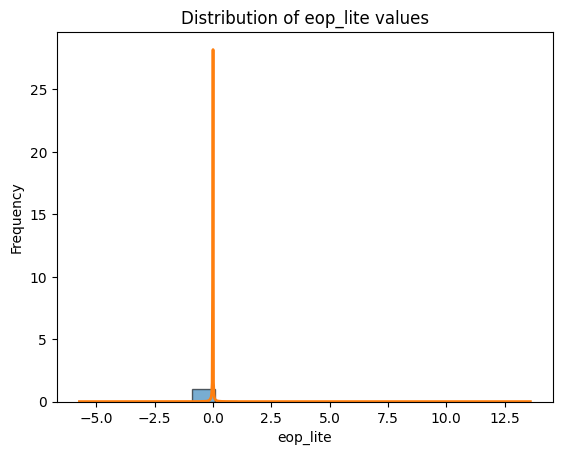

In [47]:
# Plot histogram with KDE line
plt.hist(eop['eop_lite'], bins=10, density=True, alpha=0.6, edgecolor="black", label="Histogram")
# KDE (Kernel Density Estimate)
eop['eop_lite'].plot(kind="kde", label="KDE", linewidth=2)
plt.xlabel("eop_lite")
plt.ylabel("Frequency")
plt.title("Distribution of eop_lite values")
plt.show()

In [10]:
# 2022 means per triad (adjust year if needed)
eop['year'] = pd.to_datetime(eop['month']).dt.year
means_2022 = (eop[eop['year']==2022].groupby(['i','j','k'])['eop_lite'].mean().reset_index())
print("\n2022 mean EOP‑Lite by triad:\n", means_2022)


2022 mean EOP‑Lite by triad:
       i   j   k  eop_lite
0    AR  BR  CL  0.009182
1    AR  BR  CO -0.015831
2    AR  BR  EC -0.019013
3    AR  BR  ES  0.003504
4    AR  BR  PE -0.016897
..   ..  ..  ..       ...
499  VE  US  CL -0.015126
500  VE  US  CO -0.015287
501  VE  US  EC -0.014456
502  VE  US  ES -0.016592
503  VE  US  PE -0.018443

[504 rows x 4 columns]


In [12]:
means_2022.sort_values(by='eop_lite', ascending=False).head(20)

,i,j,k,eop_lite
475,VE,CO,US,1.331286
496,VE,PE,US,1.203113
473,VE,CO,ES,0.965087
471,VE,CO,CL,0.684549
495,VE,PE,ES,0.484262
208,CO,PE,US,0.437055
223,CO,VE,US,0.326989
476,VE,EC,AR,0.272990
356,PE,CL,VE,0.225359
152,CL,PE,US,0.213401


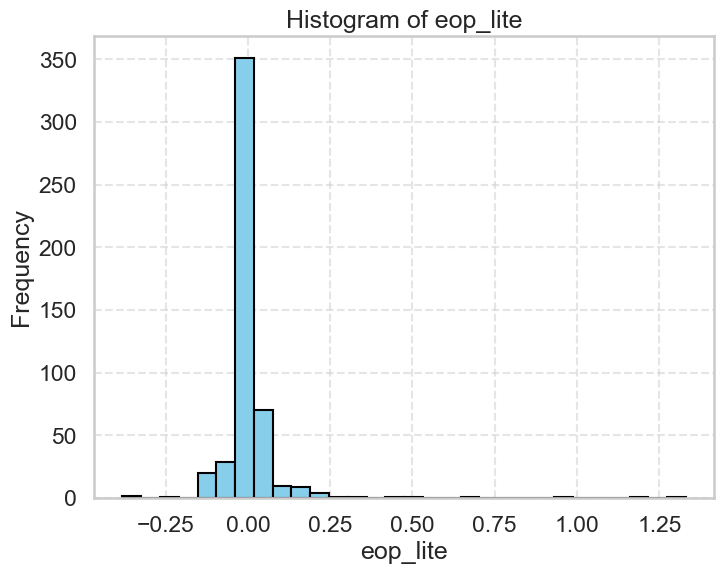

In [116]:
plt.figure(figsize=(8,6))
plt.hist(means_2022['eop_lite'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of eop_lite')
plt.xlabel('eop_lite')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot

## With policy

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # or another font that supports Unicode

ma → The moving average window size.  
It defines how many months are used to compute the smoothed EOP-Lite index.

In simple terms:
- If ma = 1 → No smoothing, you see the raw monthly EOP-Lite values.
- If ma = 3 → Each plotted point is the average of the current month + the 2 previous months.
- If ma = 6 → It averages 6 months of data, making the curve smoother but less sensitive to short-term changes.

In [6]:
# ----------  F) BEAUTIFIED PLOTS FOR ONE TRIAD (MULTIPLE POLICIES + COLORS) ----------
def plot_one_triad_pretty(
    eop_df, i, j, k, ma=3, policies=None
):
    """
    Plots:
        1) Actual vs Counterfactual flow (j->k)
        2) EOP-Lite index with moving average
    Now supports multiple policies + custom colors.

    Parameters:
    -----------
    eop_df : pd.DataFrame
        DataFrame with columns ['month', 'i', 'j', 'k', 'flow_jk', 'ehat_jk', 'eop_lite']
    i, j, k : str
        Identifiers for the triad
    ma : int, default=3
        Moving average window size
    policies : list of tuples, optional
        Each element: (policy_month, policy_name, color)
        - policy_month: str or datetime, e.g. "2020-03-01"
        - policy_name : str, optional (will display next to the vertical line)
        - color       : str, optional (matplotlib color name or hex code)
        
        Example:
            policies = [
                ("2020-03-01", "COVID Policy", "red"),
                ("2021-01-01", "Reform A", "#1f77b4"),
                ("2022-07-15", "Tax Change", "green")
            ]
    """

    # Apply seaborn theme
    sns.set(style="whitegrid", context="talk", rc={"figure.figsize": (10, 4.5)})

    # Ensure month column is datetime
    eop_df['month'] = pd.to_datetime(eop_df['month'])

    # Filter triad data
    sub = (
        eop_df[(eop_df['i'] == i) & (eop_df['j'] == j) & (eop_df['k'] == k)]
        .sort_values('month')
    )
    if sub.empty:
        print(f"No rows for triad {i}-{j}-{k}")
        return

    # Convert policy list into structured format
    policy_list = []
    if policies is not None:
        for p in policies:
            try:
                date = pd.to_datetime(p[0])
                name = p[1] if len(p) > 1 else None
                color = p[2] if len(p) > 2 else "red"  # Default color
                policy_list.append((date, name, color))
            except:
                print(f"⚠️ Skipping invalid policy: {p}")

    # ---------------------------
    # 1) Actual vs Counterfactual Flow
    # ---------------------------
    plt.figure()
    plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k', color='tab:blue', linewidth=2)
    plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', color='tab:orange',
             linestyle='--', linewidth=2)

    # Draw policies
    if policy_list:
        ylim_top = plt.ylim()[1]
        for policy_date, policy_name, color in policy_list:
            plt.axvline(x=policy_date, color=color, linestyle=':', linewidth=2)
            if policy_name:
                plt.text(policy_date, ylim_top * 0.95, policy_name, color=color,
                         rotation=90, verticalalignment='top', horizontalalignment='right', fontsize=12)

    plt.title(f"Actual vs Counterfactual for {j}→{k}\n(attribution from {i}→{j})",
              fontsize=16, weight='bold')
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Monthly Flow", fontsize=14)
    plt.legend(frameon=False, fontsize=12)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # 2) EOP-Lite (Moving Average)
    # ---------------------------
    y = sub.set_index('month')['eop_lite'].rolling(ma, min_periods=1).mean()
    plt.figure()
    plt.plot(y.index, y.values, color='tab:green', linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Draw policies
    if policy_list:
        ylim_top = plt.ylim()[1]
        for policy_date, policy_name, color in policy_list:
            plt.axvline(x=policy_date, color=color, linestyle=':', linewidth=2)
            if policy_name:
                plt.text(policy_date, ylim_top * 0.95, policy_name, color=color,
                         rotation=90, verticalalignment='top', horizontalalignment='right', fontsize=12)

    plt.title(f"EOP-Lite ({ma}-month MA) for {i}→{j}→{k}", fontsize=16, weight='bold')
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Index", fontsize=14)
    plt.tight_layout()
    plt.show()

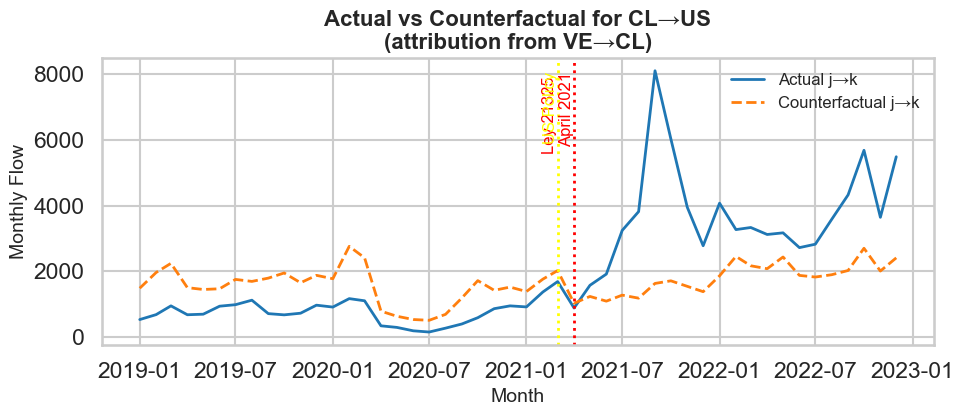

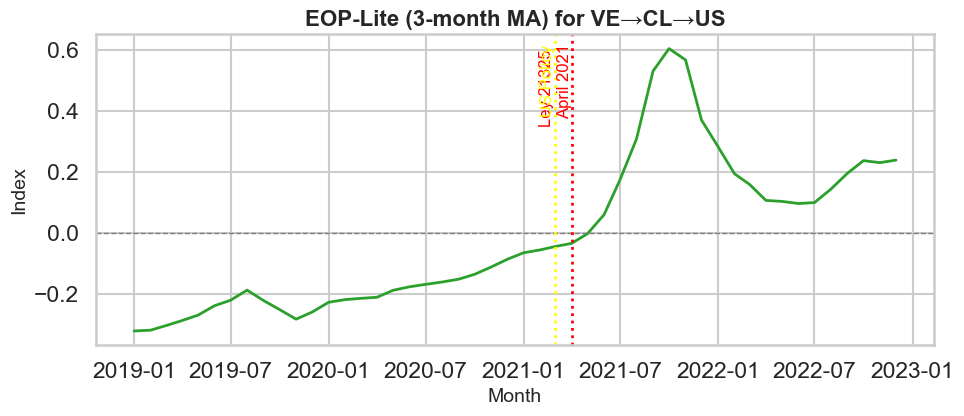

In [111]:
# CL
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

plot_one_triad_pretty(eop, i='VE', j='CL', k='US', policies = policies_CL)

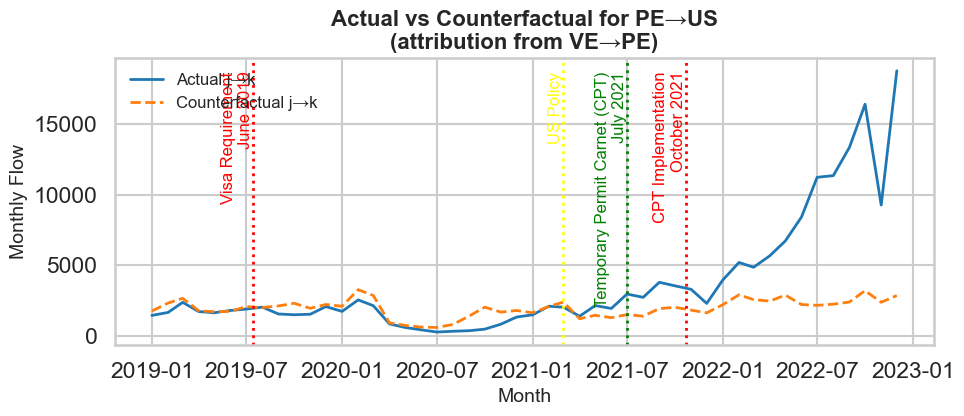

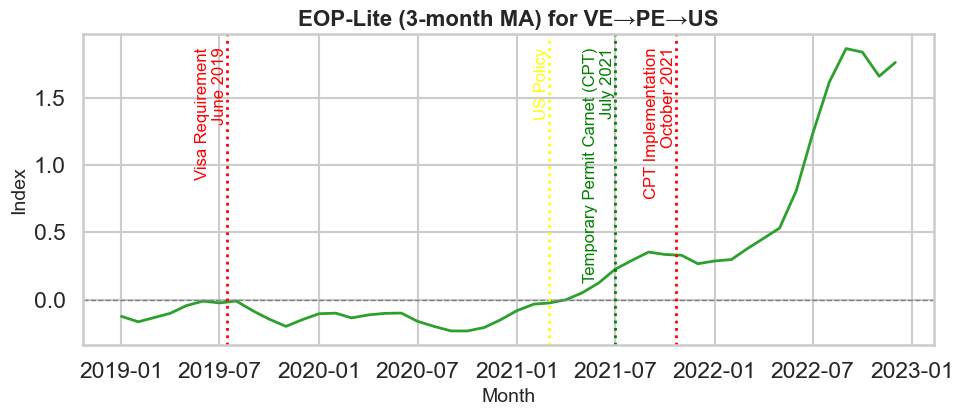

In [110]:
# PE
policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

plot_one_triad_pretty(eop, i="VE", j="PE", k="US", ma=3, policies=policies_PE)

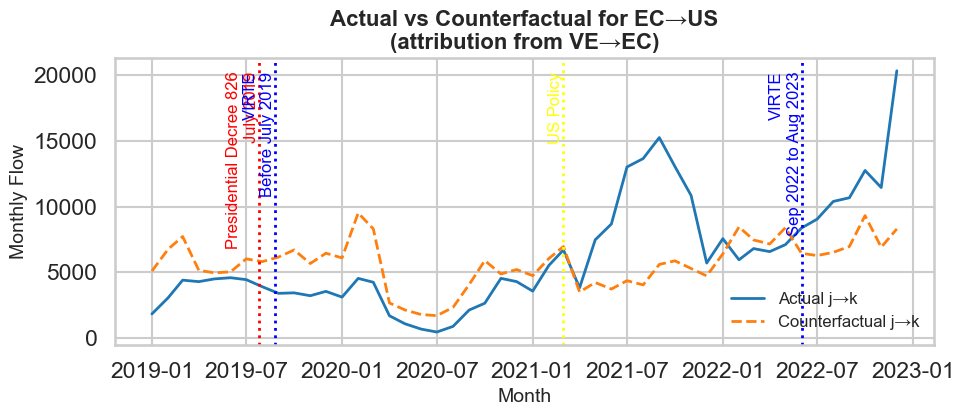

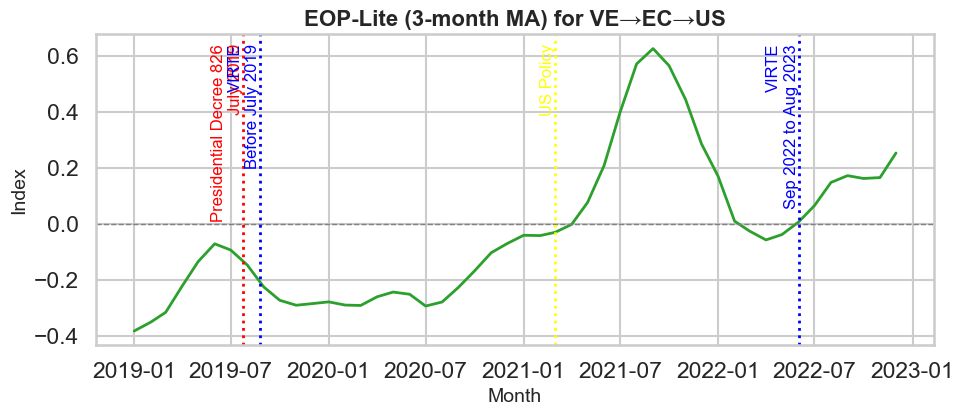

In [109]:
# EC
policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]
plot_one_triad_pretty(eop, i='VE', j='EC', k='US', policies = policies_EC)
# Visa de Residencia Temporal de Excepción = VIRTE


## Need to check more policy 

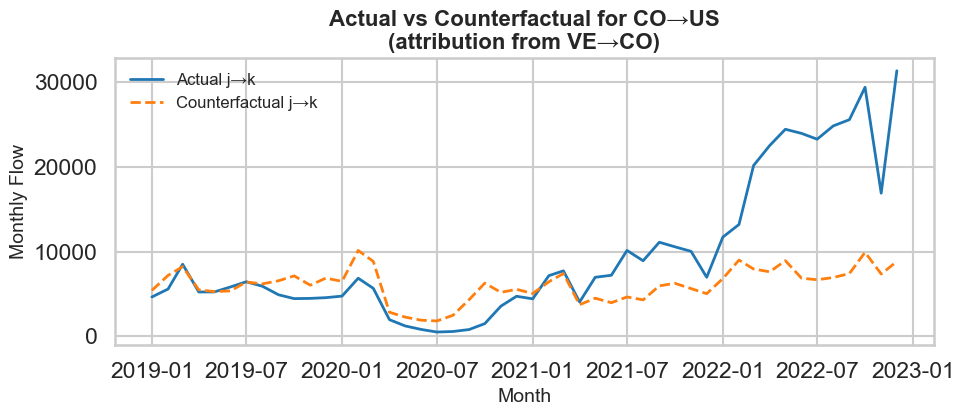

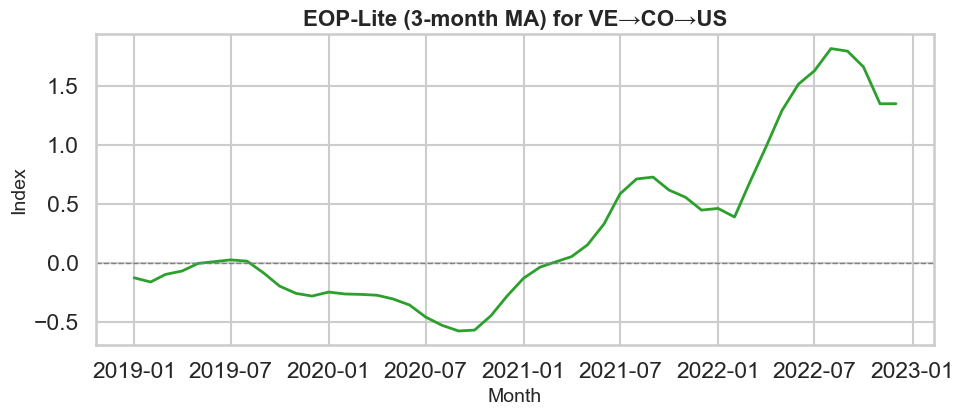

In [7]:
# CO
plot_one_triad_pretty(eop, i='VE', j='CO', k='US')

## Simple 

In [10]:
# ----------  F) QUICK PLOTS FOR ONE TRIAD ----------
def plot_one_triad(eop_df, i, j, k, ma=3):
    sub = (eop_df[(eop_df['i']==i) & (eop_df['j']==j) & (eop_df['k']==k)]
           .sort_values('month'))
    if sub.empty:
        print(f"No rows for triad {i}-{j}-{k}")
        return
    # Actual vs counterfactual for j->k
    plt.figure(figsize=(9,4))
    plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k')
    plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', linestyle='--')
    plt.title(f"Actual vs Counterfactual for {j}→{k} (attribution from {i}→{j})")
    plt.xlabel("Month"); plt.ylabel("Monthly flow"); plt.legend(); plt.tight_layout(); plt.show()

    # EOP-Lite (moving average for readability)
    y = sub.set_index('month')['eop_lite'].rolling(ma, min_periods=1).mean()
    plt.figure(figsize=(9,3))
    plt.plot(y.index, y.values)
    plt.axhline(0, linewidth=1)
    plt.title(f"EOP‑Lite ({ma}-month MA) for {i}→{j}→{k}")
    plt.xlabel("Month"); plt.ylabel("Index"); plt.tight_layout(); plt.show()

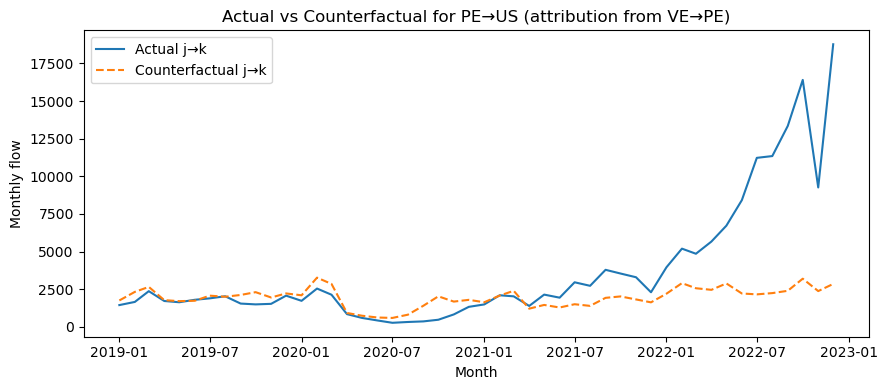

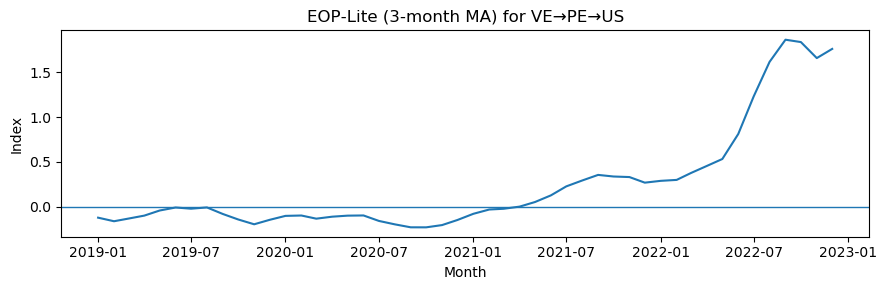

In [18]:
plot_one_triad(eop, "VE","PE","US")

# Example

In [5]:
import pandas as pd
from eop_lite import CounterfactualConfig, compute_eop_lite

In [8]:
# 1) Load your flows
df = pd.read_csv(BASE_DIR/"case_study/Migration/Excess_migration/flows_sample.csv")  # must have columns: orig, dest, month, flow
df

,orig,dest,month,flow
0,VEN,CHL,2019-01-01,2238
1,VEN,CHL,2019-02-01,2293
2,VEN,CHL,2019-03-01,2241
3,VEN,CHL,2019-04-01,2063
4,VEN,CHL,2019-05-01,2309
...,...,...,...,...
571,ECU,CHL,2022-08-01,180
572,ECU,CHL,2022-09-01,187
573,ECU,CHL,2022-10-01,187
574,ECU,CHL,2022-11-01,178


In [10]:
# 2) Choose triads
triads = [("VEN","CHL","USA"), ("VEN","PER","USA"), ("VEN","ECU","USA")]
triads

[('VEN', 'CHL', 'USA'), ('VEN', 'PER', 'USA'), ('VEN', 'ECU', 'USA')]

In [12]:
# 3) Configure (2019–2021 training → predict 2022)
cfg = CounterfactualConfig(
    train_start="2019-01-01",
    train_end="2021-12-01",
    corridor_specific_seasonality=True,  # set False to use global seasonality
    eps=1.0
)
cfg

CounterfactualConfig(train_start='2019-01-01', train_end='2021-12-01', corridor_specific_seasonality=True, eps=1.0)

In [14]:
# 4) Compute EOP‑Lite
eop_df = compute_eop_lite(df, triads, cfg)
eop_df

,i,j,k,month,flow_jk,ehat_jk,excess_jk,w_ij,eop_lite
0,VEN,CHL,USA,2019-01-01,252,253.379746,-0.005445,0.871495,-0.004746
1,VEN,CHL,USA,2019-02-01,244,242.880250,0.004610,0.869507,0.004009
2,VEN,CHL,USA,2019-03-01,246,265.834040,-0.074611,0.868316,-0.064786
3,VEN,CHL,USA,2019-04-01,221,228.919377,-0.034595,0.866686,-0.029983
4,VEN,CHL,USA,2019-05-01,275,262.644913,0.047041,0.867778,0.040821
...,...,...,...,...,...,...,...,...,...
91,VEN,PER,USA,2022-08-01,221,218.483797,0.011517,1.000000,0.011517
92,VEN,PER,USA,2022-09-01,219,207.201910,0.056940,1.000000,0.056940
93,VEN,PER,USA,2022-10-01,221,230.903232,-0.042889,1.000000,-0.042889
94,VEN,PER,USA,2022-11-01,226,233.938374,-0.033934,1.000000,-0.033934


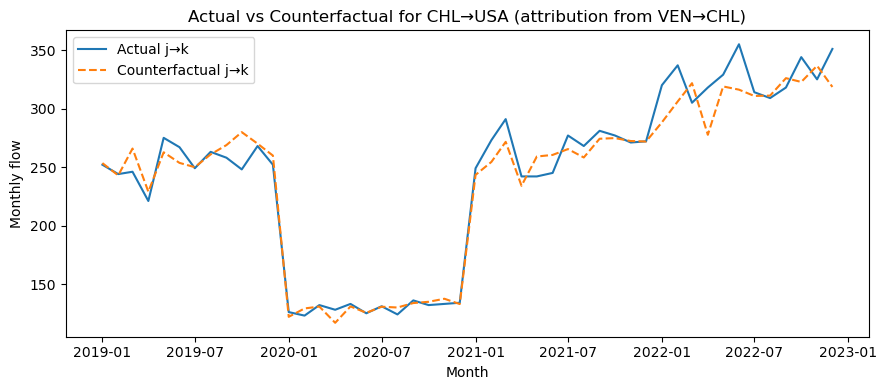

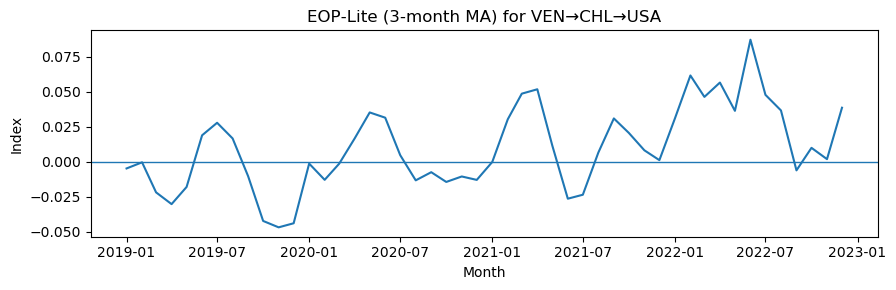

In [15]:
from eop_lite import compute_eop_lite  # already imported
import matplotlib.pyplot as plt

# Actual vs Counterfactual for j→k
sub = eop_df[(eop_df['i']=="VEN")&(eop_df['j']=="CHL")&(eop_df['k']=="USA")].sort_values('month')
plt.figure(figsize=(9,4))
plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k')
plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', linestyle='--')
plt.title("Actual vs Counterfactual for CHL→USA (attribution from VEN→CHL)")
plt.xlabel("Month"); plt.ylabel("Monthly flow"); plt.legend(); plt.tight_layout(); plt.show()

# EOP‑Lite line (3‑month moving average)
y = sub.set_index('month')['eop_lite'].rolling(3, min_periods=1).mean()
plt.figure(figsize=(9,3))
plt.plot(y.index, y.values)
plt.axhline(0, linewidth=1)
plt.title("EOP‑Lite (3‑month MA) for VEN→CHL→USA")
plt.xlabel("Month"); plt.ylabel("Index"); plt.tight_layout(); plt.show()


In [18]:
# Peak months per triad
peaks = (eop_df.sort_values(['i','j','k','eop_lite'], ascending=[True,True,True,False])
         .groupby(['i','j','k'])
         .head(1)[['i','j','k','month','eop_lite']])
peaks

,i,j,k,month,eop_lite
39,VEN,CHL,USA,2022-04-01,0.127176
97,VEN,ECU,USA,2019-02-01,0.122460
65,VEN,PER,USA,2020-06-01,0.107233


In [19]:
# 2022 annual means per triad
eop_df['year'] = pd.to_datetime(eop_df['month']).dt.year
ann_2022 = (eop_df[eop_df['year']==2022]
            .groupby(['i','j','k'])['eop_lite'].mean().reset_index())
ann_2022

,i,j,k,eop_lite
0,VEN,CHL,USA,0.041557
1,VEN,ECU,USA,0.040231
2,VEN,PER,USA,0.020838
